2025-12-29 18:32:51.978161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767033172.158928      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767033172.215817      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767033172.679801      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767033172.679843      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767033172.679846      23 computation_placer.cc:177] computation placer alr

Device: cuda
Class weights: tensor([0.6297, 2.4281], device='cuda:0')


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_23/1697247168.py:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
500,0.447200
1000,0.323900
1500,0.257900
2000,0.173100
2500,0.161200
3000,0.105900
3500,0.089000
4000,0.057500
4500,0.042300
5000,0.027900



***** Validation Metrics *****
eval_loss: 0.3426174223423004
eval_accuracy: 0.970912738214644
eval_f1: 0.9706177439942921
eval_runtime: 10.2391
eval_samples_per_second: 97.372
eval_steps_per_second: 6.153
epoch: 10.0


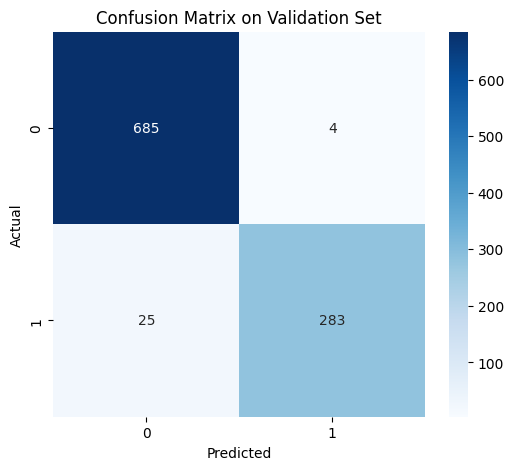

Checkpoint saved to xlmr_model_ckpt.zip


In [1]:
# =========================
# 1️⃣ Cài đặt và import
# =========================
!pip install -q transformers datasets scikit-learn torch seaborn matplotlib

import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import zipfile

# Kiểm tra GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


# =========================
# 2️⃣ Load dữ liệu
# =========================
train_df = pd.read_csv("/kaggle/input/nlp-final-prj2/train_data1.csv")
val_df   = pd.read_csv("/kaggle/input/nlp-final-prj2/val_data1.csv")

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
val_texts = val_df["text"].tolist()
val_labels = val_df["label"].tolist()

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.transform(val_labels)
classes = np.unique(train_labels)


# =========================
# 3️⃣ Class weights
# =========================
class_weights = compute_class_weight("balanced", classes=classes, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)


# =========================
# 4️⃣ Custom Dataset
# =========================
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }


# =========================
# 5️⃣ Tokenizer và Model XLM-R
# =========================
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes))
model.to(device)


# =========================
# 6️⃣ Dataset objects
# =========================
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset   = CustomDataset(val_texts, val_labels, tokenizer)


# =========================
# 7️⃣ Metrics
# =========================
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}


# =========================
# 8️⃣ TrainingArguments
# =========================
output_dir = "./xlmr_ckpt"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=2,
    learning_rate=2e-5,
    report_to=[]
)


# =========================
# 9️⃣ Weighted Trainer (fix **kwargs)
# =========================
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


# =========================
# 🔟 Train
# =========================
train_result = trainer.train()
trainer.save_model(os.path.join(output_dir, "final_model"))


# =========================
# 1️⃣1️⃣ Evaluate + Confusion Matrix
# =========================
eval_results = trainer.evaluate()
print("\n***** Validation Metrics *****")
for k, v in eval_results.items():
    print(f"{k}: {v}")

# Confusion matrix
preds_output = trainer.predict(val_dataset)
pred_labels = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(val_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()


# =========================
# 1️⃣2️⃣ Zip checkpoint
# =========================
ckpt_zip = "xlmr_model_ckpt.zip"
with zipfile.ZipFile(ckpt_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))
print(f"Checkpoint saved to {ckpt_zip}")



***** Validation Metrics *****
eval_loss: 0.3426174223423004
eval_accuracy: 0.970912738214644
eval_f1: 0.9706177439942921
eval_runtime: 10.0266
eval_samples_per_second: 99.436
eval_steps_per_second: 6.283
epoch: 10.0

Classification Report (Validation):
              precision    recall  f1-score   support

           0     0.9648    0.9942    0.9793       689
           1     0.9861    0.9188    0.9513       308

    accuracy                         0.9709       997
   macro avg     0.9754    0.9565    0.9653       997
weighted avg     0.9714    0.9709    0.9706       997



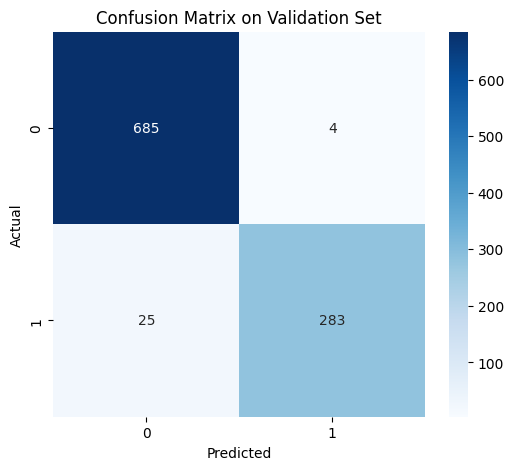

In [2]:
# =========================
# 1️⃣1️⃣ Evaluate + Classification Report + Confusion Matrix
# =========================
from sklearn.metrics import classification_report

# Evaluate (một lần nữa)
eval_results = trainer.evaluate()
print("\n***** Validation Metrics *****")
for k, v in eval_results.items():
    print(f"{k}: {v}")

# Predictions
preds_output = trainer.predict(val_dataset)
pred_labels = np.argmax(preds_output.predictions, axis=1)

# -------------------------
# Classification Report
# -------------------------
report = classification_report(val_labels, pred_labels, digits=4)
print("\nClassification Report (Validation):")
print(report)

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()
